In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Data
path = r"C:\Users\ameya\Box\UpSkill\FSDS\DataSets\PradhanData\Data\German Credit Data.csv"
df_gc = pd.read_csv(path)
df_gc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   checkin_acc        1000 non-null   object
 1   duration           1000 non-null   int64 
 2   credit_history     1000 non-null   object
 3   amount             1000 non-null   int64 
 4   savings_acc        1000 non-null   object
 5   present_emp_since  1000 non-null   object
 6   inst_rate          1000 non-null   int64 
 7   personal_status    1000 non-null   object
 8   residing_since     1000 non-null   int64 
 9   age                1000 non-null   int64 
 10  inst_plans         1000 non-null   object
 11  num_credits        1000 non-null   int64 
 12  job                1000 non-null   object
 13  status             1000 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 109.5+ KB


In [5]:
df_gc.to_csv('../data/germanCredit.csv')

In [29]:
df_gc.status.value_counts()

0    700
1    300
Name: status, dtype: int64

## Model 1

In [30]:
X_features = list(df_gc.columns); X_features.remove('status')
Target     = ['status']
df_gc_en   = pd.get_dummies(df_gc[X_features],
                            drop_first=True)

In [31]:
import statsmodels.api as sm
X = sm.add_constant(df_gc_en)
y = df_gc[Target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    random_state=42)

import statsmodels.api as sm
model = sm.Logit(y_train, X_train)
model_log = model.fit()
print( model_log.summary2() ) 

Optimization terminated successfully.
         Current function value: 0.488938
         Iterations 6
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.198     
Dependent Variable:   status            AIC:               744.5132  
Date:                 2023-01-08 23:00  BIC:               881.0456  
No. Observations:     700               Log-Likelihood:    -342.26   
Df Model:             29                LL-Null:           -426.75   
Df Residuals:         670               LLR p-value:       1.0630e-21
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                 -0.1511   1.1349 -0.1331 0.8941 -2.3754  2.0733
duration        

In [32]:
model_diagnostics = pd.DataFrame({
                                    'FEATURES' : ['Bias'] + list(df_gc_en.columns),
                                    'PVALUES'  : model_log.pvalues,
                                }).set_index('FEATURES')

model_diagnostics.sort_values('PVALUES',ascending=True)[:10]

,PVALUES
FEATURES,
checkin_acc_A14,5.388728e-10
credit_history_A34,1.814378e-03
inst_rate,1.881840e-03
amount,1.747666e-02
age,2.689338e-02
savings_acc_A65,2.724103e-02
checkin_acc_A13,3.690689e-02
duration,4.629398e-02
savings_acc_A64,6.520330e-02


In [33]:
model2Predictions = pd.DataFrame({
                                    'Y_TEST': y_test['status'],
                                    'Y_PROB': model_log.predict(X_test).tolist(),                       
                                })
model2Predictions['Y_PRED'] = model2Predictions['Y_PROB'].map( lambda x: 1 if x> 0.5 else 0)

In [34]:
# Metrics
def binary_metrics(df):
    from sklearn import metrics
    cm = metrics.confusion_matrix(df['Y_TEST'], df['Y_PRED'], labels=[1,0]);

    TP, FP, TN, FN = cm[0,0], cm[1,0], cm[1,1], cm[0,1]
    SENSITIVITY = np.round(  TP / ( TP + FN ), 2 )
    SPECIFICITY = np.round(  TN / ( TN + FP ), 2 )
    PRECESION   = np.round(  TP / ( TP + FP ), 2 )
    print( 'SENSITIVITY =', np.round(  TP / ( TP + FN ), 2 ))
    print( 'SPECIFICITY =', np.round(  TN / ( TN + FP ), 2 ))
    print( 'PRECESION   =', np.round(  TP / ( TP + FP ), 2 ))
    print( 'F_SCORE     =', np.round(  2 * SENSITIVITY * PRECESION / (SENSITIVITY + PRECESION), 2))
    print( '---------------CLASSIFICATION REPORT---------------' )
    print( metrics.classification_report(df['Y_TEST'], df['Y_PRED']) )

    # Plots
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, 
                                        sharex=False, figsize=(20, 5));

    # Confusion Matrix
    sns.heatmap(cm,
                annot=True,
                fmt='.0f',
                xticklabels=['POSITIVE' , 'NEGATIVE'],
                yticklabels=['POSITIVE' , 'NEGATIVE'],
                ax=ax0
                );
    ax0.set_ylabel('True label');
    ax0.set_xlabel('Predicted label');


    # Overlap Plots
    sns.histplot(df[df['Y_TEST'] == 1]['Y_PROB'],
                kde = True,
                color = 'b',
                label = 'BAD CREDIT',
                bins  = 20,
                ax=ax1 );

    sns.histplot(df[df['Y_TEST'] == 0]['Y_PROB'],
                kde = True,
                color = 'k',
                label = 'GOOD CREDIT',
                bins  = 20,
                ax=ax1 );

    # ROC AUC Curve
    fpr, tpr, thresholds = metrics.roc_curve(df['Y_TEST'],
                                             df['Y_PROB'],
                                             drop_intermediate=False,
                                            );

    sns.lineplot(fpr, 
                tpr,
                label = 'ROC Curve = %0.2f' %metrics.roc_auc_score(df['Y_TEST'], df['Y_PROB']),
                ax=ax2    
                );
    plt.plot([0,1],[0,1], 'k--'); plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05]);
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(), plt.show();

SENSITIVITY = 0.41
SPECIFICITY = 0.93
PRECESION   = 0.71
F_SCORE     = 0.52
---------------CLASSIFICATION REPORT---------------
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       209
           1       0.71      0.41      0.52        91

    accuracy                           0.77       300
   macro avg       0.75      0.67      0.68       300
weighted avg       0.76      0.77      0.75       300



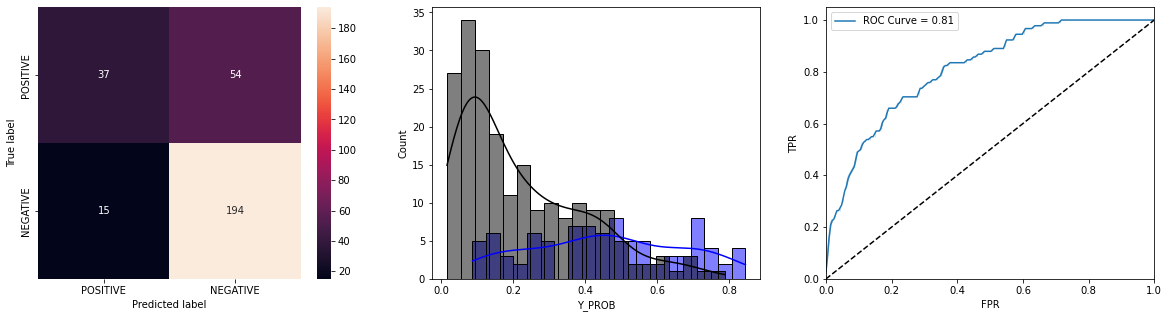

In [35]:
binary_metrics(df=model2Predictions)

# Model 2

In [36]:
significant_variables = ['checkin_acc_A14', 'credit_history_A34', 'inst_rate', 'amount', 'age', 'savings_acc_A65', 'checkin_acc_A13', 'duration' ]

In [37]:
#df_gc_en = pd.get_dummies(df_gc[significant_variables], drop_first=True)

import statsmodels.api as sm
X = sm.add_constant(df_gc_en[significant_variables])
y = df_gc[Target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    random_state=42)

import statsmodels.api as sm
model = sm.Logit(y_train, X_train)
model_log = model.fit()
print( model_log.summary2() ) 

Optimization terminated successfully.
         Current function value: 0.511350
         Iterations 6
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.161     
Dependent Variable:  status           AIC:              733.8898  
Date:                2023-01-08 23:02 BIC:              774.8495  
No. Observations:    700              Log-Likelihood:   -357.94   
Df Model:            8                LL-Null:          -426.75   
Df Residuals:        691              LLR p-value:      7.4185e-26
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
const              -0.8969   0.4364 -2.0551 0.0399 -1.7523 -0.0415
checkin_acc_A14    -1.5452   0.2187 -7.0649 0.0000 -1

In [38]:
model2Predictions = pd.DataFrame({
                                    'Y_TEST': y_test['status'],
                                    'Y_PROB': model_log.predict(X_test).tolist(),                       
                                })
model2Predictions['Y_PRED'] = model2Predictions['Y_PROB'].map( lambda x: 1 if x> 0.5 else 0)

SENSITIVITY = 0.33
SPECIFICITY = 0.9
PRECESION   = 0.59
F_SCORE     = 0.42
---------------CLASSIFICATION REPORT---------------
              precision    recall  f1-score   support

           0       0.76      0.90      0.82       209
           1       0.59      0.33      0.42        91

    accuracy                           0.73       300
   macro avg       0.67      0.61      0.62       300
weighted avg       0.70      0.73      0.70       300



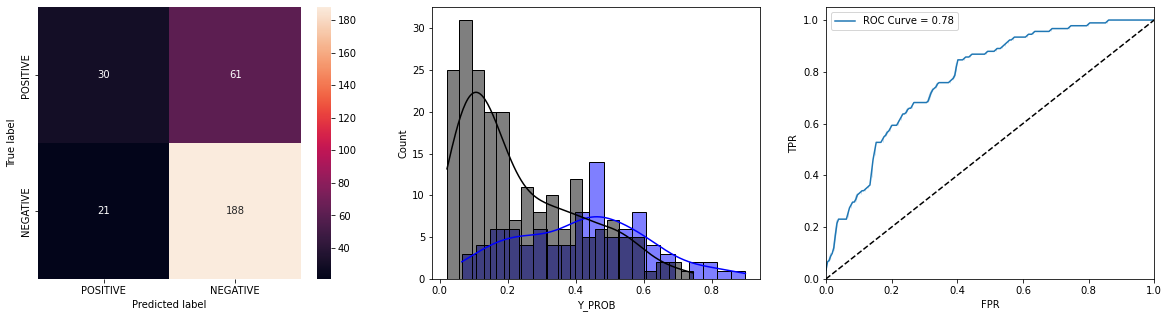

In [39]:
binary_metrics(df=model2Predictions)

# Model 3 Youden's Index
Changes Threshold from 0.5 to 0.22 on same model

In [41]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(model2Predictions['Y_TEST'],
                                         model2Predictions['Y_PROB'],
                                            drop_intermediate=False,
                                        )

In [42]:
df_tpr_fpr = pd.DataFrame({
                            'TPR' : tpr,
                            'FPR' : fpr,
                            'THR' : thresholds,
})
df_tpr_fpr['DIFF'] = df_tpr_fpr['TPR'] - df_tpr_fpr['FPR']
df_tpr_fpr.sort_values('DIFF', 
                      ascending = False,
                      ).head()

,TPR,FPR,THR,DIFF
160,0.846154,0.397129,0.221534,0.449025
161,0.846154,0.401914,0.216531,0.444240
162,0.846154,0.406699,0.215591,0.439455
159,0.835165,0.397129,0.223980,0.438036
166,0.857143,0.421053,0.207107,0.436090


In [43]:
model3Predictions = pd.DataFrame({
                                    'Y_TEST': y_test['status'],
                                    'Y_PROB': model_log.predict(X_test).tolist(),                       
                                })
model3Predictions['Y_PRED'] = model3Predictions['Y_PROB'].map( lambda x: 1 if x> 0.22 else 0)
model3Predictions.head()

,Y_TEST,Y_PROB,Y_PRED
521,1,0.452449,1
737,0,0.491820,1
740,0,0.418416,1
660,0,0.270285,1
411,0,0.132119,0


SENSITIVITY = 0.85
SPECIFICITY = 0.6
PRECESION   = 0.48
F_SCORE     = 0.61
---------------CLASSIFICATION REPORT---------------
              precision    recall  f1-score   support

           0       0.90      0.60      0.72       209
           1       0.48      0.85      0.61        91

    accuracy                           0.68       300
   macro avg       0.69      0.72      0.67       300
weighted avg       0.77      0.68      0.69       300



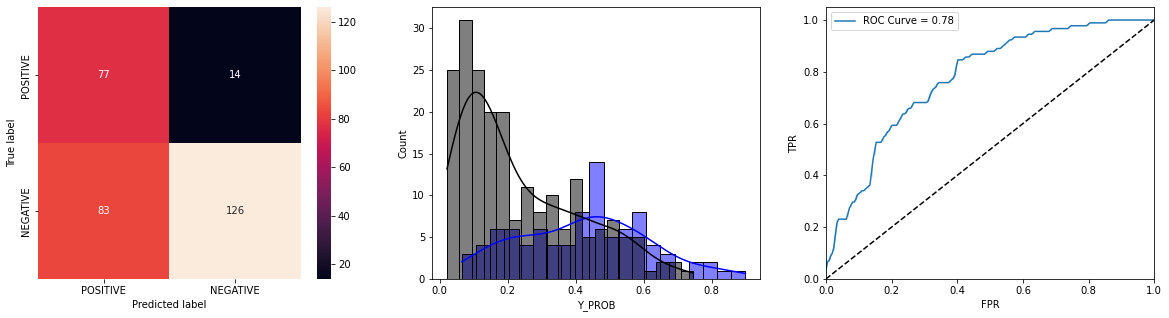

In [44]:
binary_metrics(model3Predictions)

# Model 4 Cost-based Approach
Changes threshold from 0.22 to 0.14 for same Model 2

In [45]:
def gettotalcost(Y_TEST, Y_PRED, COST_FP, COST_FN ):
    cm = metrics.confusion_matrix( Y_TEST, Y_PRED, labels=[1,0])
    cm_mat = np.array( cm )
    return cm_mat[0,1] * COST_FN + cm_mat[1,0] * COST_FP

df_cost = pd.DataFrame(columns = ['Prob', 'Cost'])

idx = 0
for each_prob in range(10, 50):
    cost = gettotalcost(Y_TEST  = model3Predictions['Y_TEST'],
                        Y_PRED  = model3Predictions['Y_PROB'].map( lambda x: 1 if x > (each_prob/100) else 0), 
                        COST_FP = 1, 
                        COST_FN = 5,
                        )
    df_cost.loc[idx] = [each_prob / 100 , cost]
    idx = idx + 1


In [46]:
df_cost.sort_values('Cost', ascending=True)[:10]

,Prob,Cost
4,0.14,150.0
12,0.22,153.0
2,0.12,154.0
10,0.20,154.0
9,0.19,156.0
5,0.15,156.0
6,0.16,157.0
11,0.21,157.0
3,0.13,158.0
7,0.17,158.0


In [47]:
model4Predictions = pd.DataFrame({
                                    'Y_TEST': y_test['status'],
                                    'Y_PROB': model_log.predict(X_test).tolist(),                       
                                })
model4Predictions['Y_PRED'] = model4Predictions['Y_PROB'].map( lambda x: 1 if x> 0.14 else 0)
model4Predictions.head()

,Y_TEST,Y_PROB,Y_PRED
521,1,0.452449,1
737,0,0.491820,1
740,0,0.418416,1
660,0,0.270285,1
411,0,0.132119,0


SENSITIVITY = 0.93
SPECIFICITY = 0.43
PRECESION   = 0.41
F_SCORE     = 0.57
---------------CLASSIFICATION REPORT---------------
              precision    recall  f1-score   support

           0       0.94      0.43      0.59       209
           1       0.41      0.93      0.57        91

    accuracy                           0.58       300
   macro avg       0.68      0.68      0.58       300
weighted avg       0.78      0.58      0.58       300



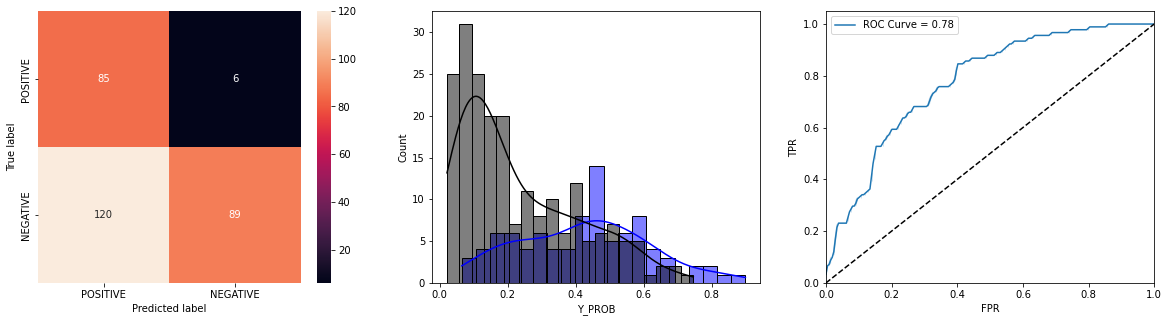

In [48]:
binary_metrics(model4Predictions)